# SMA Crossover Strategy (Hourly BTC)
This notebook demonstrates a simple trading strategy that uses
**Simple Moving Average (SMA) crossovers** to generate buy and sell signals.
 
#### Strategy Logic
- **Buy Entry (Golden Cross)**: When the 20-SMA crosses **above** the 50-SMA
- **Sell Exit (Death Cross)**: When the 20-SMA crosses **below** the 50-SMA
 
We'll run this strategy on hourly BTCUSDT data using a custom backtesting engine.
### Before we begin, we load and process our data, and calculate the necessary indicators.


In [1]:
import pandas as pd
from overfitting import Strategy

In [2]:
def load_data():
    df = pd.read_csv('./data/BTCUSDT.csv')
    df['timestamp'] = pd.to_datetime(df['open_time'], unit='ms')
    df.set_index('timestamp', inplace=True)
    df.drop(columns=['open_time'], inplace=True)

    start_time = pd.to_datetime('2023-01-01 00:00:00')
    df = df.loc[start_time:]
    # Compute short and long SMAs
    df['sma_short'] = df['close'].rolling(window=20).mean().shift()
    df['sma_long'] = df['close'].rolling(window=50).mean().shift()

    return df

backtest_data = load_data()
print(backtest_data.head())


                        open     high      low    close    volume  \
timestamp                                                           
2023-01-01 00:00:00  16537.5  16540.9  16504.0  16527.0  5381.399   
2023-01-01 01:00:00  16527.1  16554.3  16524.1  16550.4  3210.826   
2023-01-01 02:00:00  16550.5  16557.1  16534.8  16542.4  2399.668   
2023-01-01 03:00:00  16542.5  16542.5  16515.0  16529.3  3214.480   
2023-01-01 04:00:00  16529.2  16530.4  16508.8  16517.8  3150.954   

                        close_time  sma_short  sma_long  
timestamp                                                
2023-01-01 00:00:00  1672534799999        NaN       NaN  
2023-01-01 01:00:00  1672538399999        NaN       NaN  
2023-01-01 02:00:00  1672541999999        NaN       NaN  
2023-01-01 03:00:00  1672545599999        NaN       NaN  
2023-01-01 04:00:00  1672549199999        NaN       NaN  


## The strategy works as follows:

### Buy Entry (Golden Cross)
- When the 20-period SMA crosses **above** the 50-period SMA
- And there is **no existing position**

### Exit (Death Cross)
- When the 20-period SMA crosses **below** the 50-period SMA
- And a **long position is open**

📈 The strategy trades the **BTCUSDT** pair on **hourly data**, allocating the **entire balance** to each trade.


In [3]:
class MyStrategy(Strategy):
    def init(self):
        self.asset = 'BTC'
        self.set_leverage(self.asset, 1)

    def next(self, i):
        short = self.data.sma_short[i]
        long = self.data.sma_long[i]

        # Skip if SMA values aren't available yet
        if pd.isna(short) or pd.isna(long):
            return

        prev_short = self.data.sma_short[i - 1]
        prev_long = self.data.sma_long[i - 1]

        # Also skip if previous values are not available
        if pd.isna(prev_short) or pd.isna(prev_long):
            return

        price = self.data.open[i]
        lot_size = self.get_balance() // price
        p = self.get_position(self.asset)

        # Golden cross (entry)
        if prev_short <= prev_long and short > long and p.qty == 0:
            self.limit_order(self.asset, lot_size, price)

        # Death cross (exit)
        if prev_short >= prev_long and short < long and p.qty > 0:
            self.market_order(self.asset, -p.qty)


### Let's run the strategy and plot the results.


Performance Summary
Number of Years               1.70000000
Start Date           2023-01-01 00:00:00
End Date             2024-08-29 00:00:00
Initial Balance         100,000.00000000
Final Balance           202,802.51658000
CAGR                          0.51576326
Cumulative Return             2.02802517
Sharpe Ratio                  1.22963908
Sortino Ratio                 3.50674547
Max Drawdown                 -0.27312998
Daily Value At Risk          -0.04143807
Skew                          0.31909418
Kurtosis                      2.60022470
Total Trades                181.00000000
Winning Trades               68.00000000
Losing Trades               113.00000000
Win Rate (%)                 37.56906077
Gross Profit            391,161.01938000
Gross Loss             -288,358.50280000
Net Profit              102,802.51658000
Avg Return (%)                0.38386677
Avg Profit (%)                3.53708812
Avg Loss (%)                 -1.51364697
  Net drawdown in %  Peak date Valley

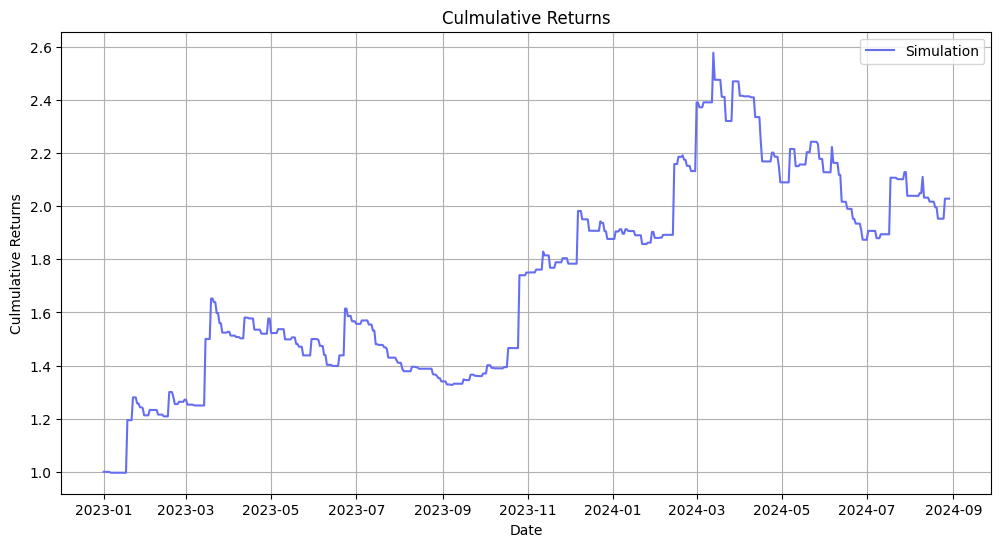

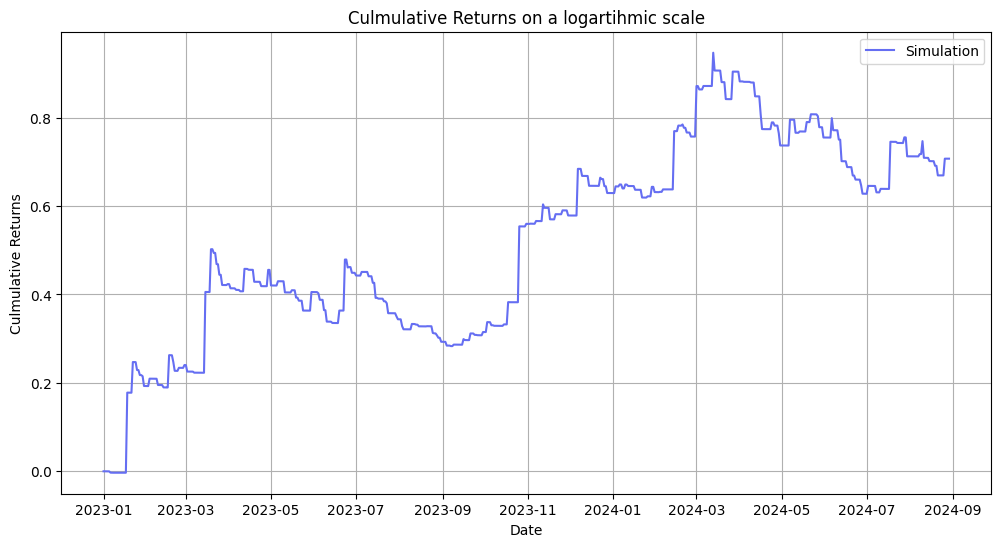

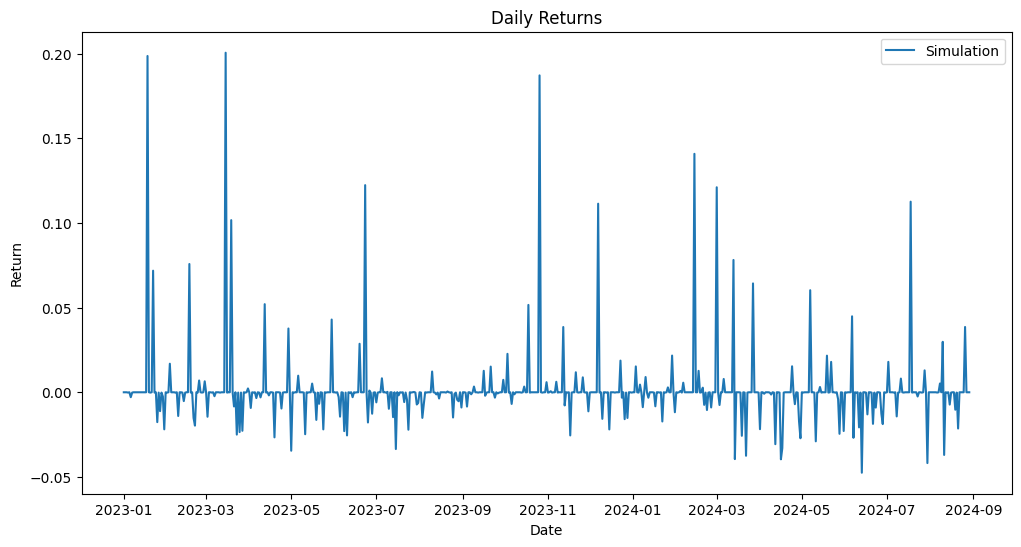

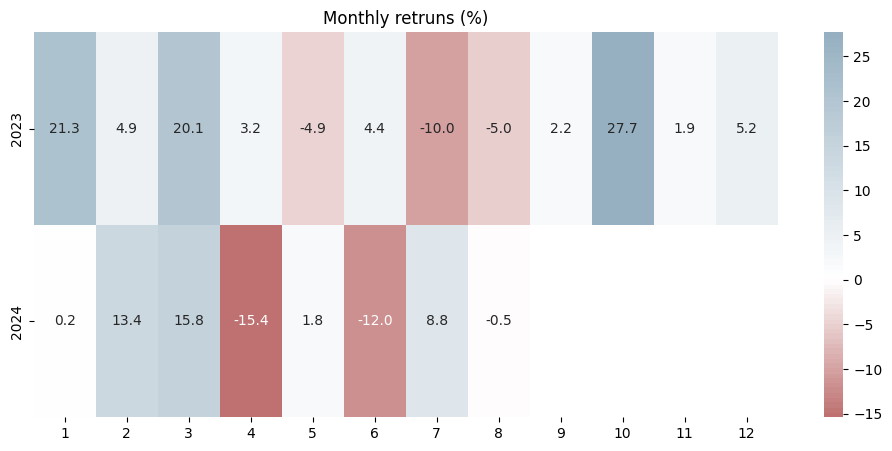

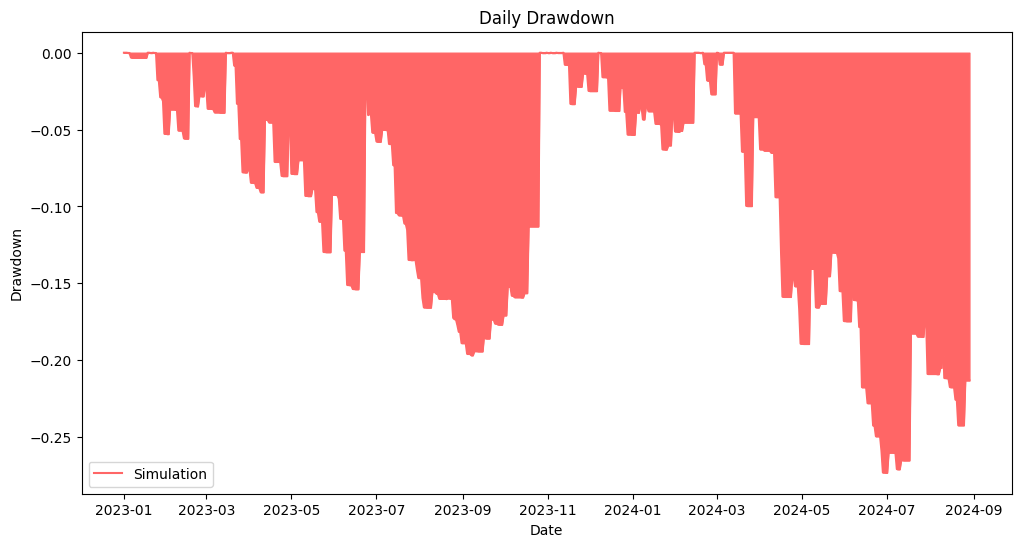

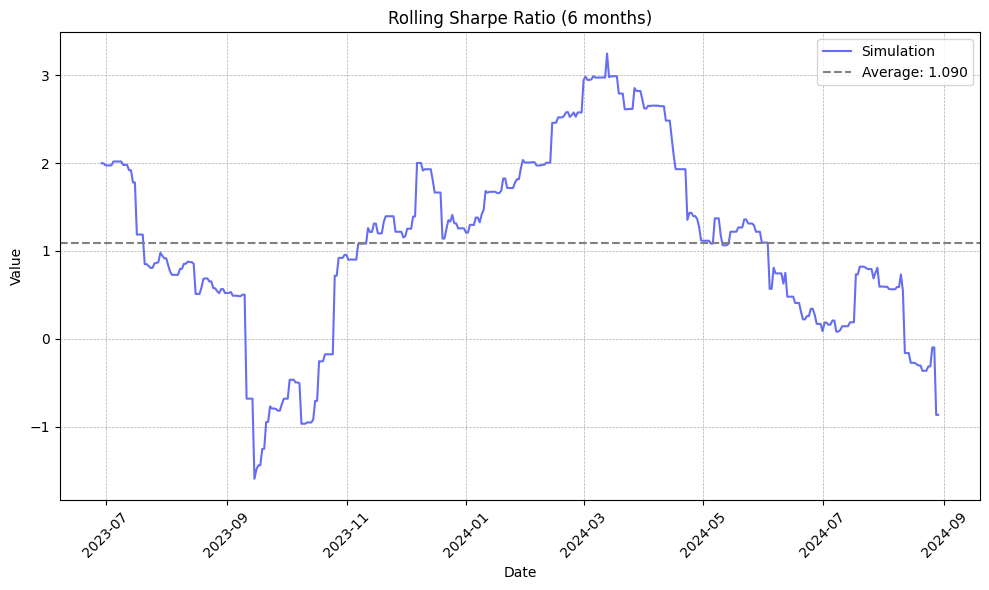

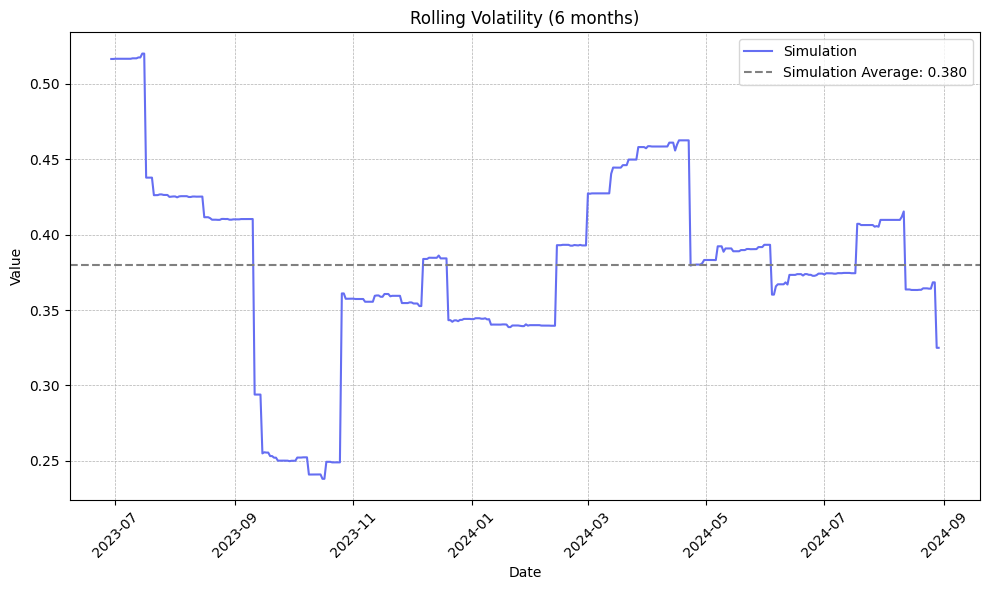

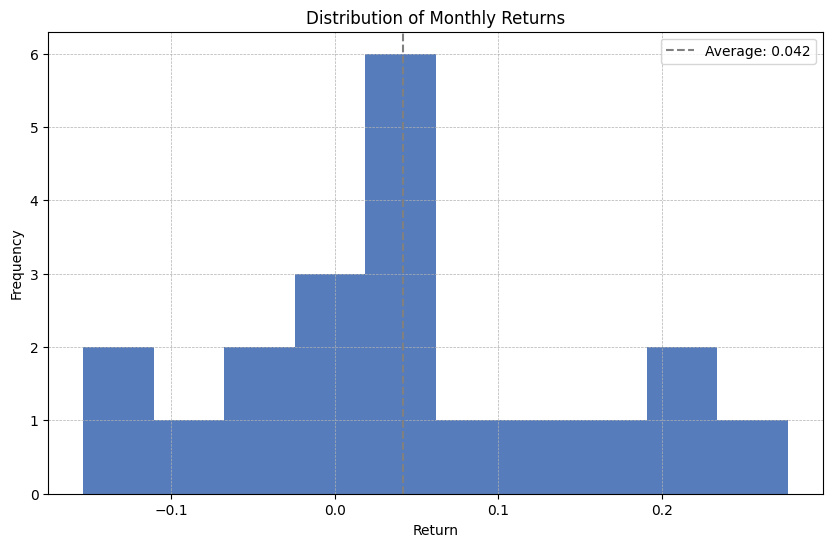

In [4]:
strategy = MyStrategy(
    data=backtest_data,
    initial_capital=100_000,
    commission_rate=0.0002,
    maint_maring_rate=0.005,
    maint_amount=50  
)
returns = strategy.run()
strategy.plot(returns)

#### You can also fetch the trade history for analysis.

In [5]:
strategy.fetch_trades()

,id,created_at,symbol,qty,price,type,status,stop_price,is_triggered,reason,executed_price,commission,pnl,realized_pnl
0,9d04b1eec8bd4933,2023-01-04 07:00:00,BTC,5.0,16872.8,LIMIT,FILLED,None,False,None,16872.8,16.87280,0.0,-16.87280
1,4ef55dbb9d654cc0,2023-01-06 02:00:00,BTC,-5.0,16818.1,MARKET,FILLED,None,False,None,16818.1,16.81810,-273.5,-290.31810
2,4665b8c630ca4803,2023-01-07 01:00:00,BTC,5.0,16969.9,LIMIT,FILLED,None,False,None,16969.9,16.96990,0.0,-16.96990
3,f9424244a4304aec,2023-01-18 19:00:00,BTC,-5.0,20933.3,MARKET,FILLED,None,False,None,20933.3,20.93330,19817.0,19796.06670
4,32041b79d936432d,2023-01-20 08:00:00,BTC,5.0,20954.1,LIMIT,FILLED,None,False,None,20954.1,20.95410,0.0,-20.95410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,0e26468229a34270,2024-08-21 08:00:00,BTC,-3.0,59689.2,MARKET,FILLED,None,False,None,59689.2,35.81352,-4198.8,-4234.61352
359,daa50e4e888946a4,2024-08-21 23:00:00,BTC,3.0,61145.8,LIMIT,FILLED,None,False,None,61145.8,36.68748,0.0,-36.68748
360,bff7cf84502a46f3,2024-08-26 02:00:00,BTC,-3.0,63893.3,MARKET,FILLED,None,False,None,63893.3,38.33598,8242.5,8204.16402
361,c673a3749c6a4909,2024-08-26 03:00:00,BTC,3.0,64033.0,LIMIT,FILLED,None,False,None,64033.0,38.41980,0.0,-38.41980
